[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Weeds Identification-Transfer Learning-5

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Cotton-100619-Healthy-zz-V1-20210225102300**, **Black nightsade-220519-Weed-zz-V1-20210225102034**, **Tomato-240519-Healthy-zz-V1-20210225103740** and **Velvet leaf-220519-Weed-zz-V1-20210225104123** datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_tensorflow_transfer_learning.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (possibly) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only some layers of the pre-trained network. Its promise is that the training will be more efficient and in the best of the cases the performance will be better compared to a model trained from scratch. In this example we are using MobileNet architectures.

**MobileNet V1**, with its appearance in 2017, started a new path of deep learning research in computer vision: models that can run in **embedded devices**. This lead to several important works including ShuffleNet(V1 and V2), MNasNet, CondenseNet, and EffNet (among others). Due to its success, new versions of MobileNet have also appeared more recently. These new versions included new advances, such as **Inverted Residual Block** or the use of **Neural Architecture Search** for optimizing the creation of new neural components. **MobileNet Versions 2 (Sandler et al., 2018) and 3 (Howard et al., 2019)** are used as an example in this notebook.

In **agriculture**, since **weeds** compete with crops in the domain of space, light and nutrients, they are an important problem that can lead to a poorer harvest by farmers. To avoid this, weeds should be removed at every step of the growth, but especially at the initial stages. For that reason, identifying weeds accurately by deep learning has arisen as an important objective. Related to this, we can find the disease detection problem, where transfer learning has also been used. Among the most relevant recent works, we can find:

**Wang et al., (2017)** used transfer learning in order to obtain the best neural-based method for disease detection in plants. They extended the apple black rot images in the PlantVillage dataset, which were further annotated by botanists with four severity stages as ground truth. Then, they evaluated the performances of shallow networks trained from scratch and deep models fine-tuned by transfer learning. Their best model was the **VGG16** architecture trained with transfer learning, which yielded an overall accuracy of 90.4% on the hold-out test set. In **Mehdipour-Ghazi et al., (2017)**, the authors used the plant datasets of LifeCLEF 2015. Three popular deep learning architectures were evaluated: **GoogLeNet, AlexNet, and VGGNet**.  Their best combined system (a combination of GoogleNet and VGGNet) achieved an overall accuracy of 80% on the validation set and an overall inverse rank score of 0.752 on the official test set. In **Suh et al., (2018)**, the authors compared different transfer learning approaches in order to find a suitable approach for weed detection (volunteer potato). Their highest classification accuracy for **AlexNet** was 98.0%. Comparing different networks, their highest classification accuracy  was 98.7%, which was obtained with **VGG-19**. Additionally, all scenarios and pre-trained networks were feasible for real-time applications (classification time < 0.1 s). Another relevant study has been performed by **Kounalakis et al., (2019)** where they evaluated transfer learning by a combination of CNN-based feature extraction and linear classifiers to recognize rumex under real-world conditions. Their best system (**Inception_v1**+L2regLogReg) achieved an accuracy of 96.13 with a false positive rate of 3.62. In **Too et al., (2019)**, the authors used transfer learning achieving a performance of 99.75% with the **DenseNet** architecture. Finally, in **Espejo-Garcia et al., (2020)**, authors used transfer learning using agricultural datasets for pre-training neural networks, and afterwards, they fine-tuned the networks for classifying 4 species extracted from the **Eden Platform**. Their maximum performance was 99.54% by using the **Xception** architecture.

It is important to note that in this notebook a technique integrating neural-network feature-extraction and "traditional" machine learning algorithms is used. This technique was used in **Kounalakis et al., (2019)** and **Espejo-Garcia et al., (2020)**, and represents an extension over the previous Eden notebooks:
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-1.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-2.ipynb
3. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-3.ipynb
4. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-4.ipynb

### Library Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import csv
import gc
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

### Auxiliary functions
Check the docstrings for more information.

In [2]:
def plot_sample(X):
    """
    Given the array of images <X>, it plots a random subsample of 9 of them.

        Parameters:
            X (ndarray): The array with all the images.
    """
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])


def read_data(path_list, im_size=(224, 224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
    """
    X = []
    y = []

    # Extract filenames of the datasets we ingest and create a label dictionary
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV reads with BGR format, convert to RGB
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)

    return X, y


def get_callbacks(weights_file, patience, lr_factor):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.
            lr_factor: Factor for reducing the learning rate when performance
                       is not improving.

        Returns:
            callbacks (List[Callbacks]): Configured callback ready for using.
    """
    return [
        # Only save weights that correspond to the maximum validation accuracy
        ModelCheckpoint(
            filepath=weights_file,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        # If val_loss does not improve after a number of epochs (patience),
        # training will stop to avoid overfitting.
        EarlyStopping(monitor="val_loss", mode="min", patience=patience, verbose=1),
        # Learning rate is reduced by 'lr_factor' if val_loss stagnates
        # for a number of epochs (patience).
        # ReduceLROnPlateau(monitor="val_loss", mode="min",
        #                  factor=lr_factor, min_lr=1e-6, patience=patience//2, verbose=1 )
    ]


def plot_performances(performances):
    """
    Given the list of performances (validation accuracies) and method-name <performances>,
    it plots how the validation accuracy progressed during the training/validation process.

        Parameters:
            performances (List[Tuple]): The list of method-performance tuples.
    """
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    for performance in performances:
        plt.plot(
            range(1, len(performance[1]) + 1), performance[1], label=performance[0]
        )
    plt.ylim((0.5, 1.05))
    plt.xticks(np.arange(1, NUM_EPOCHS + 1, 1.0))
    plt.legend()
    plt.show()

### Experimental Constants

In [3]:
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
NUM_EPOCHS = 20
BATCH_SIZE = 4
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 2021
WEIGHTS_FILE = "weights.h5"  # File to store updated weights

# Eden datasets we will work on
PATH_LIST = [
    "Cotton-100619-Healthy-zz-V1-20210225102300",
    "Black nightsade-220519-Weed-zz-V1-20210225102034",
    "Tomato-240519-Healthy-zz-V1-20210225103740",
    "Velvet leaf-220519-Weed-zz-V1-20210225104123",
]

### Loading images and Data Loaders

In [4]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(
        Path(Path.cwd()).parents[0].joinpath("eden_library_datasets").joinpath(path)
    )
    i += 1
X, y = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 129/129 [00:31<00:00,  4.11it/s]


### Plot sample images

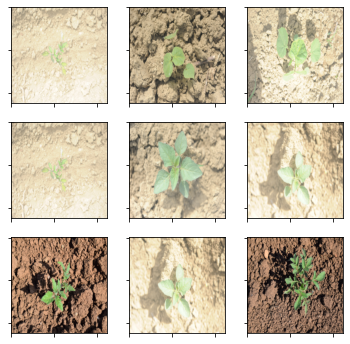

In [5]:
plot_sample(X)

In [6]:
def get_architecture(y, mobilenet_version, as_feature_extractor):
    """
    This function returns a pre-trained Tensorflow MobileNet architecture.
    Versions 2 and 3-Large are available.

        Parameters:
            y (ndarray): Array with labels. It is used for computing the number of classes.
            mobilenet_version (string): which MobileNet version to import (2 or 3 Large).
            as_feature_extractor (Boolean): Whether to fine-tune the "convolutional" layers.

        Returns:
            model (Model): MobileNet architecture ready for training.
    """

    if mobilenet_version == "2":
        feature_extractor = MobileNetV2(
            weights="imagenet",  # Load weights pre-trained on ImageNet
            include_top=False,  # Do not include the ImageNet classifier at the top
            input_shape=INPUT_SHAPE,
        )
    elif mobilenet_version == "3":
        feature_extractor = MobileNetV3Large(
            weights="imagenet",  # Load weights pre-trained on ImageNet
            include_top=False,  # Do not include the ImageNet classifier at the top
            input_shape=INPUT_SHAPE,
        )

    # Freeze the base_model,we don't want to update initial weights
    if as_feature_extractor:
        feature_extractor.trainable = False
    else:
        feature_extractor.trainable = True  # Not necessary

    # Create new model on top.
    x = layers.GlobalAveragePooling2D(name="pool")(
        feature_extractor.output
    )  # Flattening layer
    x = layers.Dense(units=64, activation="relu")(x)  # Fully connected layer
    # Create a Classifier with shape=number_of_training_classes.
    x = layers.Dropout(0.3)(x)  # Regularize with dropout.
    out = layers.Dense(units=y.shape[1], activation="softmax")(x)
    model = Model(feature_extractor.input, out)  # Final model

    # Defining base learning rate for Adam optimizer
    base_learning_rate = 1e-4
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
        metrics=["accuracy"],
    )

    return model

### Training vs Fine-Tuning Models
When using transfer learning, there are several strategies for reusing the weights or the knowledge learned on another task. Here 2 strategies are shown and compared:

1. **Feature Extraction**: The weights of the pre-trained architecture are not updated (the layers are frozen). This way, the architecture is used as a feature extractor while the last layer or classifier is trained to make sense of these features in the new problem.
2. **Fine-Tuning**: The weights of the pre-trained architecture are updated. The number of layers that are trained depends on the specific problem addressed and many times there is not a predefined best option.

In [7]:
X_prep = tf.keras.applications.mobilenet_v3.preprocess_input(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_prep,
    y, 
    test_size=TEST_SPLIT, 
    shuffle=True, 
    stratify=y, 
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=VAL_SPLIT,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

In [8]:
model = get_architecture(y, mobilenet_version="2", as_feature_extractor=True)

history_v2_fe = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(WEIGHTS_FILE, NUM_EPOCHS // 2, 0.25),
)

model.load_weights(WEIGHTS_FILE)
final_accuracy = model.evaluate(X_test, y_test, batch_size=1, verbose=0)[1]
print("*" * 72)
print(f"Final MobileNetV2 (Feature Extraction) Accuracy: {final_accuracy}")
print("*" * 72)

Epoch 1/20
80/80 [==============================] - 6s 56ms/step - loss: 1.3755 - accuracy: 0.4344 - val_loss: 1.0574 - val_accuracy: 0.6500
Epoch 2/20
80/80 [==============================] - 4s 49ms/step - loss: 1.0204 - accuracy: 0.6031 - val_loss: 0.9086 - val_accuracy: 0.6250
Epoch 3/20
80/80 [==============================] - 4s 51ms/step - loss: 0.9348 - accuracy: 0.6406 - val_loss: 0.8375 - val_accuracy: 0.6750
Epoch 4/20
80/80 [==============================] - 4s 48ms/step - loss: 0.7829 - accuracy: 0.7125 - val_loss: 0.7806 - val_accuracy: 0.6875
Epoch 5/20
80/80 [==============================] - 4s 50ms/step - loss: 0.7482 - accuracy: 0.7281 - val_loss: 0.7264 - val_accuracy: 0.6875
Epoch 6/20
80/80 [==============================] - 4s 49ms/step - loss: 0.6840 - accuracy: 0.7656 - val_loss: 0.7084 - val_accuracy: 0.7125
Epoch 7/20
80/80 [==============================] - 4s 49ms/step - loss: 0.6588 - accuracy: 0.7750 - val_loss: 0.6626 - val_accuracy: 0.6875
Epoch 8/20
80

In [9]:
model = get_architecture(y, mobilenet_version="2", as_feature_extractor=False)

history_v2_ft = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(WEIGHTS_FILE, NUM_EPOCHS // 2, 0.25),
)
model.load_weights(WEIGHTS_FILE)
final_accuracy = model.evaluate(X_test, y_test, batch_size=1, verbose=0)[1]
print("*" * 72)
print(f"Final MobileNetV2 (Fine-Tuning) Accuracy: {final_accuracy}")
print("*" * 72)

Epoch 1/20
80/80 [==============================] - 25s 287ms/step - loss: 0.9497 - accuracy: 0.5938 - val_loss: 1.5658 - val_accuracy: 0.3750
Epoch 2/20
80/80 [==============================] - 26s 321ms/step - loss: 0.4912 - accuracy: 0.8281 - val_loss: 1.3171 - val_accuracy: 0.3625
Epoch 3/20
80/80 [==============================] - 23s 283ms/step - loss: 0.2738 - accuracy: 0.9031 - val_loss: 1.3349 - val_accuracy: 0.4625
Epoch 4/20
80/80 [==============================] - 23s 294ms/step - loss: 0.2752 - accuracy: 0.9156 - val_loss: 1.4152 - val_accuracy: 0.4750
Epoch 5/20
80/80 [==============================] - 22s 281ms/step - loss: 0.2558 - accuracy: 0.9094 - val_loss: 1.7777 - val_accuracy: 0.5250
Epoch 6/20
80/80 [==============================] - 21s 268ms/step - loss: 0.1960 - accuracy: 0.9312 - val_loss: 1.8518 - val_accuracy: 0.5625
Epoch 7/20
80/80 [==============================] - 21s 267ms/step - loss: 0.1309 - accuracy: 0.9625 - val_loss: 1.5597 - val_accuracy: 0.6000

In [10]:
X_prep = mobilenet_v3.preprocess_input(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_prep, 
    y, 
    test_size=TEST_SPLIT, 
    shuffle=True, 
    stratify=y, 
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=VAL_SPLIT,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

In [11]:
model = get_architecture(y, mobilenet_version="3", as_feature_extractor=True)

history_v3_fe = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(WEIGHTS_FILE, NUM_EPOCHS // 2, 0.25),
)

model.load_weights(WEIGHTS_FILE)
final_accuracy = model.evaluate(X_test, y_test, batch_size=1, verbose=0)[1]
print("*" * 72)
print(f"Final MobileNetV3 (Feature Extraction) Accuracy: {final_accuracy}")
print("*" * 72)

Epoch 1/20
80/80 [==============================] - 7s 60ms/step - loss: 1.1392 - accuracy: 0.5344 - val_loss: 0.8491 - val_accuracy: 0.6500
Epoch 2/20
80/80 [==============================] - 4s 51ms/step - loss: 0.6999 - accuracy: 0.7719 - val_loss: 0.6801 - val_accuracy: 0.7250
Epoch 3/20
80/80 [==============================] - 4s 51ms/step - loss: 0.5378 - accuracy: 0.8313 - val_loss: 0.5307 - val_accuracy: 0.8375
Epoch 4/20
80/80 [==============================] - 4s 51ms/step - loss: 0.3953 - accuracy: 0.8844 - val_loss: 0.4520 - val_accuracy: 0.8625
Epoch 5/20
80/80 [==============================] - 4s 51ms/step - loss: 0.3484 - accuracy: 0.9187 - val_loss: 0.3977 - val_accuracy: 0.8875
Epoch 6/20
80/80 [==============================] - 4s 54ms/step - loss: 0.3217 - accuracy: 0.9062 - val_loss: 0.3559 - val_accuracy: 0.9000
Epoch 7/20
80/80 [==============================] - 4s 52ms/step - loss: 0.2609 - accuracy: 0.9281 - val_loss: 0.3151 - val_accuracy: 0.9125
Epoch 8/20
80

In [12]:
model = get_architecture(y, mobilenet_version="3", as_feature_extractor=False)

history_v3_ft = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(WEIGHTS_FILE, NUM_EPOCHS // 2, 0.25),
)

model.load_weights(WEIGHTS_FILE)
final_accuracy = model.evaluate(X_test, y_test, batch_size=1, verbose=0)[1]
print("*" * 72)
print(f"Final MobileNetV3 (Fine Tuning) Accuracy: {final_accuracy}")
print("*" * 72)

Epoch 1/20
80/80 [==============================] - 23s 254ms/step - loss: 1.1188 - accuracy: 0.5469 - val_loss: 0.9398 - val_accuracy: 0.6000
Epoch 2/20
80/80 [==============================] - 20s 250ms/step - loss: 0.6907 - accuracy: 0.7188 - val_loss: 0.6367 - val_accuracy: 0.7625
Epoch 3/20
80/80 [==============================] - 21s 258ms/step - loss: 0.3004 - accuracy: 0.8969 - val_loss: 0.4886 - val_accuracy: 0.8000
Epoch 4/20
80/80 [==============================] - 21s 260ms/step - loss: 0.2457 - accuracy: 0.9187 - val_loss: 0.3991 - val_accuracy: 0.8375
Epoch 5/20
80/80 [==============================] - 21s 266ms/step - loss: 0.1495 - accuracy: 0.9563 - val_loss: 0.1898 - val_accuracy: 0.9500
Epoch 6/20
80/80 [==============================] - 21s 262ms/step - loss: 0.0669 - accuracy: 0.9781 - val_loss: 0.1758 - val_accuracy: 0.9375
Epoch 7/20
80/80 [==============================] - 26s 323ms/step - loss: 0.1111 - accuracy: 0.9688 - val_loss: 0.1496 - val_accuracy: 0.9625

### Plotting model performances

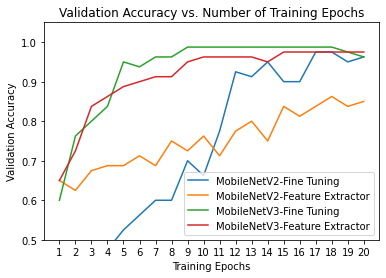

In [13]:
plot_performances([
    ("MobileNetV2-Fine Tuning", history_v2_ft.history["val_accuracy"]),
    ("MobileNetV2-Feature Extractor", history_v2_fe.history["val_accuracy"]),
    ("MobileNetV3-Fine Tuning", history_v3_ft.history["val_accuracy"]),
    ("MobileNetV3-Feature Extractor", history_v3_fe.history["val_accuracy"]),
])

## Possible Extensions
1. Use a different pre-trained network (e.g.: MobileNetV3Small).
2. Try a different training approach where pre-trained weights are not loaded.
3. Try different learning rates (0.0001 in this notebook) or even other optimization algorithms (e.g.: SGD).
4. Try different epochs and batch sizes.

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

Sandler, M., Howard, A.G., Zhu, M., Zhmoginov, A., & Chen, L. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 4510-4520.

Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.

https://www.tensorflow.org/api_docs/python/tf/keras/applications